In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
#r'dataset_license\train\images\31--0132_jpg.rf.ddd1188f8c3d7700749cb4fbff6f047f.jpg'
image = cv2.imread('car2.png', cv2.IMREAD_GRAYSCALE) #gray scale로 jpg 파일 불러오기
image.shape #이미지 shape 확인하고 resize 예정

(223, 594)

Text(0.5, 1.0, 'binary')

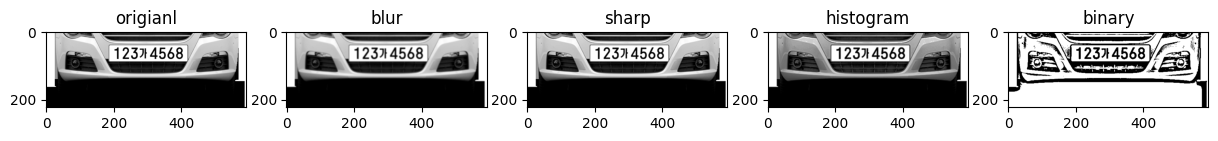

In [4]:
#추후에 이미지를 분석하는 모델에 넣어야 해서 그때 사용되는 시간을 줄이기 위해 리사이즈 실시
#여기서 하는 것은 하나의 이미지를 리사이즈 하고 가능한 선명하게 하는게 목적 
#일단 리사이즈 전의 이미지가 선명한건 알겠는데 각각의 정확도와 시간의 차이가 얼마나 생기는지가 관건이다(전부 돌린 후 지울 주석)
#image_128 = cv2.resize(image,(128,128)) #리사이즈 하기에는 너무 값이 제대로 안 나와서 일단 대기

image_blur = cv2.GaussianBlur(image, ksize=(5,5), sigmaX=0)#이미지를 잘 인식시키기위해 가우시안 블러 사용

kernel = np.array([[0,-1,0],
                   [-1,5,-1],
                   [0,-1,0]]) #커널 생성
image_sharp = cv2.filter2D(image_blur,-1,kernel) # 블러 처리 된 이미지를 선명화 시키는 작업

image_histogram = cv2.equalizeHist(image_sharp) #이미지 평활화-> 객체 형태가 두드러지도록 만들어줌

#선명화된 이미지를 이진화 처리(영역마다 빛 조건이 달라질 때 도움이 됨) -> 번호판은 빛 조건이 달라 질 수 있어서 이진화를 함
#cv2.adaptiveThreshold(입력 이미지, 최댓값, 적응형 이진화 플래그, 임곗값 형식, 블록 크기, 감산값)
max_output_value = 255 #출력 픽셀 강도의 최대값을 결정
neighborhood_size = 51 #블록의 크기(홀수만 가능)
substract_from_mean = 10 #감산값
image_binarized = cv2.adaptiveThreshold(image_histogram, max_output_value,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY,neighborhood_size,substract_from_mean)#적응적 임계처리를 적용
#cv2.ADAPTIVE_THRESH_GAUSSIAN_C 픽셀의 임계값을 주변 픽셀 강도의 가중치 합으로 설정
#cv2.ADAPTIVE_THRESH_MEAN_C는 픽셀의 임계값을 주변 픽셀의 평균으로 설정

fig, ax = plt.subplots(1,5, figsize=(15,10))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('origianl')
#ax[1].imshow(image_128, cmap='gray')
#ax[1].set_title('128size') #이걸로 리사이즈 하니까 너무 그림의 값이 안나오긴 함 고려 잘해야겠음
ax[1].imshow(image_blur, cmap='gray')
ax[1].set_title('blur')
ax[2].imshow(image_sharp, cmap='gray')
ax[2].set_title('sharp')
ax[3].imshow(image_histogram, cmap='gray')
ax[3].set_title('histogram')
ax[4].imshow(image_binarized, cmap='gray')
ax[4].set_title('binary')

Text(0.5, 1.0, 'binary')

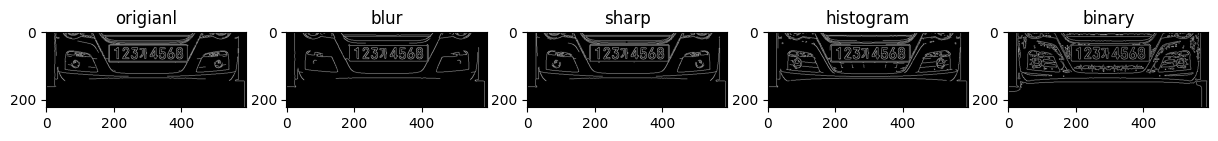

In [5]:
#cv2.canny(image,threshold1,threshold2) #이미지의 외곽선을 검출해주는 함수
# 픽셀 강도의 중간값을 계산
median_intensity = np.median(image_binarized)

# 중간 픽셀 강도에서 위아래 1 표준편차 떨어진 값을 임곗값으로 지정
lower_threshold = int(max(0, (1.0 - 0.3) * median_intensity)) #threshold2로 검증된 엣지의 주변이 엣지의 연장선인지 판단하는 임계값, 값이 작을 수록 연장선으로 판단
upper_threshold = int(min(255, (1.0 + 0.3) * median_intensity))#엣지인지 판단하는 임계값, 값이 작을 수록 연장선으로 판단
# Canny edge detection 적용
image_canny_ori = cv2.Canny(image, lower_threshold, upper_threshold)
#image_canny_128 = cv2.Canny(image_128, lower_threshold, upper_threshold)
image_canny_blur = cv2.Canny(image_blur, lower_threshold, upper_threshold)
image_canny_sharp = cv2.Canny(image_sharp, lower_threshold, upper_threshold)
image_canny_his = cv2.Canny(image_histogram, lower_threshold, upper_threshold)
image_canny_bi = cv2.Canny(image_binarized, lower_threshold, upper_threshold)


fig, ax = plt.subplots(1,5, figsize=(15,10))
ax[0].imshow(image_canny_ori, cmap='gray')
ax[0].set_title('origianl')
#ax[1].imshow(image_canny_128, cmap='gray')
#ax[1].set_title('128size')
ax[1].imshow(image_canny_blur, cmap='gray')
ax[1].set_title('blur')
ax[2].imshow(image_canny_sharp, cmap='gray')
ax[2].set_title('sharp')
ax[3].imshow(image_canny_his, cmap='gray')
ax[3].set_title('histogram')
ax[4].imshow(image_canny_bi, cmap='gray')
ax[4].set_title('binary')
#흠.... 현재 결과까지만 봐서는 이진화를 하는 이유를 모르겠네 선명화에서 끝내도 될 거 같은데(추후 삭제)

Text(0.5, 1.0, 'binary')

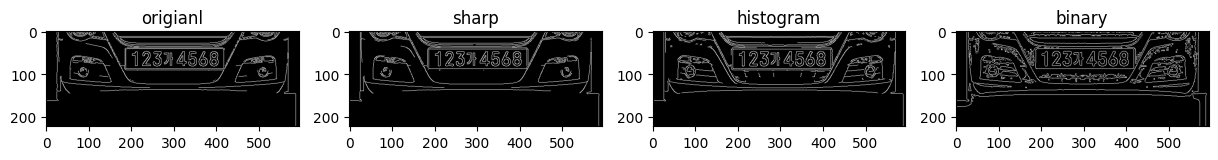

In [6]:
height, width = image.shape
#orginal
contours1, hierachy1 = cv2.findContours(
    image_canny_ori,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)
#sharp
contours2, hierachy2 = cv2.findContours(
    image_canny_sharp,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)
#histogram
contours3, hierachy3 = cv2.findContours(
    image_canny_his,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)
#binary
contours4, hierachy4 = cv2.findContours(
    image_canny_bi,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result1 = np.zeros((height, width), dtype=np.uint8)
temp_result2 = np.zeros((height, width), dtype=np.uint8)
temp_result3 = np.zeros((height, width), dtype=np.uint8)
temp_result4 = np.zeros((height, width), dtype=np.uint8)

cv2.drawContours(temp_result1, contours=contours1, contourIdx=-1, color=(255,255,255))
cv2.drawContours(temp_result2, contours=contours2, contourIdx=-1, color=(255,255,255))
cv2.drawContours(temp_result3, contours=contours3, contourIdx=-1, color=(255,255,255))
cv2.drawContours(temp_result4, contours=contours4, contourIdx=-1, color=(255,255,255))

fig, ax = plt.subplots(1,4, figsize=(15,10))
ax[0].imshow(temp_result1, cmap='gray')
ax[0].set_title('origianl')
#ax[1].imshow(temp_result1, cmap='gray')
#ax[1].set_title('blur')
ax[1].imshow(temp_result2, cmap='gray')
ax[1].set_title('sharp')
ax[2].imshow(temp_result3, cmap='gray')
ax[2].set_title('histogram')
ax[3].imshow(temp_result4, cmap='gray')
ax[3].set_title('binary')
#여기까지 해보니 이진화의 최적 파라미터를 못 구해서 그런가 샤프가 더 나은 선택인것 처럼 보인다
# 이 다음 부터는 샤프랑 이진화 이렇게 2개만 가지고 진행을 해봐야겠다

Text(0.5, 1.0, 'binary')

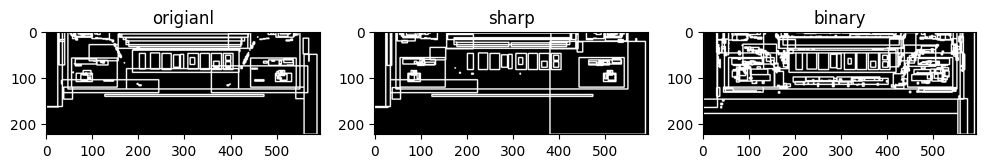

In [7]:
temp_result1 = np.zeros((height, width), dtype=np.uint8)
temp_result2 = np.zeros((height, width), dtype=np.uint8)
temp_result4 = np.zeros((height, width), dtype=np.uint8)

contours_dict = []
#original
for contour in contours1:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result1, pt1=(x,y), pt2=(x+w, y+h), color=(255,255,255), thickness=2)
    
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })
#sharp    
for contour in contours2:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result2, pt1=(x,y), pt2=(x+w, y+h), color=(255,255,255), thickness=2)
    
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })
#binary
for contour in contours4:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result4, pt1=(x,y), pt2=(x+w, y+h), color=(255,255,255), thickness=2)
    
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })
    
fig,ax = plt.subplots(1,3,figsize=(12,10))
ax[0].imshow(temp_result1, cmap='gray')
ax[0].set_title('origianl')
ax[1].imshow(temp_result2, cmap='gray')
ax[1].set_title('sharp')
ax[2].imshow(temp_result4, cmap='gray')
ax[2].set_title('binary')

Text(0.5, 1.0, 'binary')

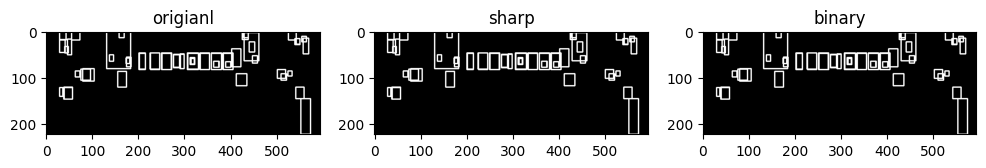

In [8]:
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT=2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
#여기에서 임시값을 지정을 해줘야 밑에서 결과 값이 위에 contour한 것과 다르게 나온다 근데 왜 다르지?
temp_result1 = np.zeros((height, width), dtype = np.uint8)
temp_result2 = np.zeros((height, width), dtype = np.uint8)
temp_result3 = np.zeros((height, width), dtype = np.uint8)

#original
for d in possible_contours:
    cv2.rectangle(temp_result1, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)
#sharp
for d in possible_contours:
    cv2.rectangle(temp_result2, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)
#binary
for d in possible_contours:
    cv2.rectangle(temp_result3, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)
    
fig,ax = plt.subplots(1,3,figsize=(12,10))
ax[0].imshow(temp_result1, cmap='gray')
ax[0].set_title('origianl')
ax[1].imshow(temp_result2, cmap='gray')
ax[1].set_title('sharp')
ax[2].imshow(temp_result3, cmap='gray')
ax[2].set_title('binary')

대한민국 번호판 구별법
1.번호판 Contours의 width와 height의 비율은 모두 동일하거나 비슷하다.
2,번호판 Contours 사이의 간격은 일정하다.
3,최소 3개 이상 Contours가 인접해 있어야한다. (대한민국 기준)

Text(0.5, 1.0, 'binary')

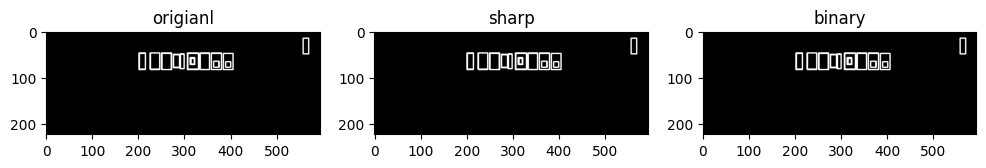

In [9]:
MAX_DIAG_MULTIPLYER = 5
MAX_ANGLE_DIFF = 12.0
MAX_AREA_DIFF = 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3

def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue
                
            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])
            
            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)
            
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']
            
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])
                
        matched_contours_idx.append(d1['idx'])
        
        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue
            
        matched_result_idx.append(matched_contours_idx)
        
        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])
        
        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)
            
        break
        
    return matched_result_idx

result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
    
temp_result1 = np.zeros((height, width), dtype=np.uint8)
temp_result2 = np.zeros((height, width), dtype=np.uint8)
temp_result3 = np.zeros((height, width), dtype=np.uint8)

#original
for r in matched_result:
    for d in r:
        cv2.rectangle(temp_result1, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255,255,255), thickness=2)
#sharp
for r in matched_result:
    for d in r:
        cv2.rectangle(temp_result2, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255,255,255), thickness=2)
#binary
for r in matched_result:
    for d in r:
        cv2.rectangle(temp_result3, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255,255,255), thickness=2)

fig,ax = plt.subplots(1,3,figsize=(12,10))
ax[0].imshow(temp_result1, cmap='gray')
ax[0].set_title('origianl')
ax[1].imshow(temp_result2, cmap='gray')
ax[1].set_title('sharp')
ax[2].imshow(temp_result3, cmap='gray')
ax[2].set_title('binary')

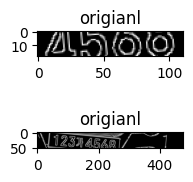

In [10]:
PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs_ori = []
plate_infos_ori = []
plate_imgs_sharp = []
plate_infos_sharp = []
plate_imgs_bi = []
plate_infos_bi = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    
    img_rotated_ori = cv2.warpAffine(image_canny_ori, M=rotation_matrix, dsize=(width, height))
    img_rotated_sharp = cv2.warpAffine(image_canny_sharp, M=rotation_matrix, dsize=(width, height))
    img_rotated_bi = cv2.warpAffine(image_canny_bi, M=rotation_matrix, dsize=(width, height))
    
    #original
    img_cropped_ori = cv2.getRectSubPix(
        img_rotated_ori, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped_ori.shape[1] / img_cropped_ori.shape[0] < MIN_PLATE_RATIO or img_cropped_ori.shape[1] / img_cropped_ori.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs_ori.append(img_cropped_ori)
    plate_infos_ori.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    #sharp
    img_cropped_sharp = cv2.getRectSubPix(
        img_rotated_sharp, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped_sharp.shape[1] / img_cropped_sharp.shape[0] < MIN_PLATE_RATIO or img_cropped_sharp.shape[1] / img_cropped_sharp.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs_sharp.append(img_cropped_sharp)
    plate_infos_sharp.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })

    #binary

    img_cropped_bi = cv2.getRectSubPix(
        img_rotated_bi, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped_bi.shape[1] / img_cropped_bi.shape[0] < MIN_PLATE_RATIO or img_cropped_bi.shape[1] / img_cropped_bi.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs_bi.append(img_cropped_bi)
    plate_infos_bi.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 3, i+1)
    plt.imshow(img_cropped_ori, cmap='gray')
    plt.title('origianl')
    # plt.imshow(img_cropped_sharp, cmap='gray')
    # # ax[1].set_title('sharp')
    # plt.imshow(img_cropped_bi, cmap='gray')
    # # ax[2].set_title('binary')

Text(0.5, 1.0, 'sharp')

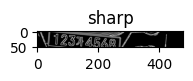

In [11]:
plt.subplot(len(matched_result), 3, i+1)
plt.imshow(img_cropped_sharp, cmap='gray')
plt.title('sharp')

Text(0.5, 1.0, 'binary')

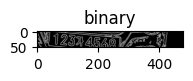

In [12]:
plt.subplot(len(matched_result), 3, i+1)
plt.imshow(img_cropped_bi, cmap='gray')
plt.title('binary')

In [13]:
%pip install pytesseract

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


갭끓밝히0
쿡났쾅2욜개갱혁떫길핏갠힝77


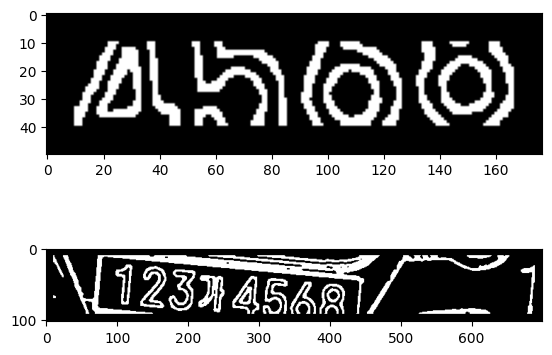

In [14]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs_ori):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again (same as above)
    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    img_result = cv2.GaussianBlur(img_result, ksize=(5, 5), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    
    pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe" #테서랙트 다운 받아서 연결
    chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7 --oem 0')
    
    result_chars = ''
    has_digit = False
    for c in chars:
        if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
            if c.isdigit():
                has_digit = True
            result_chars += c
    
    print(result_chars)
    plate_chars.append(result_chars)

    if has_digit and len(result_chars) > longest_text:
        longest_idx = i

    plt.subplot(len(plate_imgs_ori), 1, i+1)
    plt.imshow(img_result, cmap='gray')